In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
!pip install transformers --quiet
!pip install rouge-score

import numpy as np
import tensorflow as tf
from tensorflow import keras
import heapq
import random

from keras.models import save_model, load_model
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


from transformers import logging
logging.set_verbosity_error()

import pickle
import os
import pandas as pd
import re
import unicodedata

import nltk
from nltk.corpus import stopwords
from rouge_score import rouge_scorer
from nltk.translate import meteor_score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=881c6ed81fc4d5551df5d65c7b1c2293d985da2c883e784bf7c70867665fa25e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [6]:
# Set directory

os.chdir('/content/drive/MyDrive/Recipe_Generation')

In [5]:
# Load the data and inspect a few rows

recipe_df = pd.read_pickle('recipe_df.pkl')

print('Records in dataframe:',len(recipe_df))
recipe_df.head()


Records in dataframe: 116449


,key_id,title,ingredients,instructions
0,05zEpbSqcs9E0rcnCJWyZ9OgdH0MLby,Christmas Eggnog,12 egg whites\n12 egg yolks\n1 1/2 cups sugar\...,"Beat the egg whites until stiff, gradually add..."
1,mF5SZmoqxF4WtIlhLRvzuKk.z6s7P2S,"Veal, Carrot and Chestnut Ragoût",18 fresh chestnuts\n2 1/2 pounds veal stew mea...,Preheat oven to 400 degrees F. Using small sha...
2,oQV5D7cVbCFwmrDs3pBUv2y.AG0WV26,Caramelized Bread Pudding with Chocolate and C...,"2 tablespoons unsalted butter, softened\n4 or ...",Preheat the oven to 350 degrees F. Spread the ...
3,Z9seBJWaB5NkSp4DQHDnCAUBTwov/1u,Sherried Stilton and Green Peppercorn Spread,"3/4 pound Stilton, crumbled (about 3 cups) and...","In a food processor blend the Stilton, the cre..."
4,bB3GxoAplVZeoX3fzWNWyeECtQFxw6G,Almond-Chocolate Macaroons,"2 cups (about 9 1/2 ounces) whole almonds, toa...",Position rack in center of oven and preheat to...


In [ ]:
# Print some examples

for index in range(5):
    print(f"RECIPE {index + 1}: \n")
    for col in recipe_df.columns:
        print(f"{col}: {recipe_df.loc[index, col]}")
        print('\n')
    print()


RECIPE 1: 

key_id: 05zEpbSqcs9E0rcnCJWyZ9OgdH0MLby


title: Christmas Eggnog 


ingredients: 12 egg whites
12 egg yolks
1 1/2 cups sugar
3/4 cup rye whiskey
12 egg whites
3/4 cup brandy
1/2 cup rum
1 to 2 cups heavy cream, lightly whipped
Garnish: ground nutmeg


instructions: Beat the egg whites until stiff, gradually adding in 3/4 cup sugar. Set aside. Beat the egg yolks until they are thick and pale and add the other 3/4 cup sugar and stir in rye whiskey. Blend well. Fold the egg white mixture into the yolk mixture and add the brandy and the rum. Beat the mixture well. To serve, fold the lightly whipped heavy cream into the eggnog. (If a thinner mixture is desired, add the heavy cream unwhipped.) Sprinkle the top of the eggnog with the nutmeg to taste. 



RECIPE 2: 

key_id: mF5SZmoqxF4WtIlhLRvzuKk.z6s7P2S


title: Veal, Carrot and Chestnut Ragoût 


ingredients: 18 fresh chestnuts
2 1/2 pounds veal stew meat, cut into 2x1-inch pieces
4 tablespoons olive oil
1 1/2 cups chopped oni

In [ ]:
# Some additional preprocessing beyond what is done in the other script

# Function to preprocess key text fields
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove accented characters and normalize text
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    # Remove text between parentheses
    text = re.sub(r'\([^()]*\)', '', text)
    # Replace newline characters with space
    text = text.replace('\n', '. ')
    # Replace '-' with spaces
    text = text.replace('-', ' ')
    # Insert space after comma if not already present
    text = re.sub(r'(?<=\w),(?=\w)', ', ', text)
    # Remove asterisks
    text = text.replace('*', '')
    # Remove punctuation
    text = re.sub(r'[^\w\s.]', '', text)
    return text

# Apply preprocessing to all necessary columns
for col in ['title', 'ingredients','instructions']:
    recipe_df[col] = recipe_df[col].apply(preprocess_text)

for index in range(5):  # Iterate through the first five rows to take a look at the output
    print(f"RECIPE {index + 1}: \n")
    for col in recipe_df.columns:
        print(f"{col}: {recipe_df.loc[index, col]}")
        print('\n')
    print()

RECIPE 1: 

key_id: 05zEpbSqcs9E0rcnCJWyZ9OgdH0MLby


title: christmas eggnog 


ingredients: 12 egg whites. 12 egg yolks. 1 12 cups sugar. 34 cup rye whiskey. 12 egg whites. 34 cup brandy. 12 cup rum. 1 to 2 cups heavy cream lightly whipped. garnish ground nutmeg


instructions: beat the egg whites until stiff gradually adding in 34 cup sugar. set aside. beat the egg yolks until they are thick and pale and add the other 34 cup sugar and stir in rye whiskey. blend well. fold the egg white mixture into the yolk mixture and add the brandy and the rum. beat the mixture well. to serve fold the lightly whipped heavy cream into the eggnog.  sprinkle the top of the eggnog with the nutmeg to taste. 



RECIPE 2: 

key_id: mF5SZmoqxF4WtIlhLRvzuKk.z6s7P2S


title: veal carrot and chestnut ragout 


ingredients: 18 fresh chestnuts. 2 12 pounds veal stew meat cut into 2x1 inch pieces. 4 tablespoons olive oil. 1 12 cups chopped onion. 1 12 tablespoons chopped garlic. 1 bay leaf. 2 12 cups canned lo

# Small Word2Vec model (NOT USED!)

Included to demonstrate some initial embedding experimentation that was done. Ultimately, GloVe embeddings (see below) were used instead.
This small embedding model is trained from scratch from a sample of Wikipedia

In [1]:
import gensim.downloader as api
from gensim.models import Word2Vec

# Load a corpus or dataset for training an embedding model
corpus = api.load('text8')
api.info("text8")  # retrieve information about text8 dataset


[==================================================] 100.0% 31.6/31.6MB downloaded


{'num_records': 1701,
 'record_format': 'list of str (tokens)',
 'file_size': 33182058,
 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/text8/__init__.py',
 'license': 'not found',
 'description': 'First 100,000,000 bytes of plain text from Wikipedia. Used for testing purposes; see wiki-english-* for proper full Wikipedia datasets.',
 'checksum': '68799af40b6bda07dfa47a32612e5364',
 'file_name': 'text8.gz',
 'read_more': ['http://mattmahoney.net/dc/textdata.html'],
 'parts': 1}

In [2]:
# Train Word2Vec model with some vocabulary size and embedding dimension
vec_model = Word2Vec(sentences=corpus, vector_size=20, window=7, min_count=5, workers=4)

# Save the trained Word2Vec model
vec_model.save("word2vec_model")

[==================================================] 100.0% 31.6/31.6MB downloaded


In [3]:

# Constants for special tokens
UNK_TOKEN = '<UNK>'
START_TOKEN = '<START>'
END_TOKEN = '<END>'
PAD_TOKEN = '<PAD>'
NUM_TOKEN = '<NUM>'
SPECIAL_TOKENS = [UNK_TOKEN, START_TOKEN, END_TOKEN, PAD_TOKEN, NUM_TOKEN]

# Initialize vocab dictionary
EMBEDDING_DIM = vec_model.vector_size
vocab_size = len(vec_model.wv.key_to_index) + len(SPECIAL_TOKENS)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
print('Embedding matrix shape is:', embedding_matrix.shape)
vocab_dict = {}

# Build the embedding matrix and vocabulary dictionary
for i, word in enumerate(vec_model.wv.index_to_key):
    embedding_vector = vec_model.wv[word]

    # Assign the embedding vector to the embedding matrix
    embedding_matrix[i] = embedding_vector
    vocab_dict[word] = i

# Add embeddings for special tokens
for i, token in enumerate(SPECIAL_TOKENS, start=len(vec_model.wv.index_to_key)):
    if token == PAD_TOKEN:
        # Use zero vectors for padding token
        embedding_matrix[i] = np.zeros(EMBEDDING_DIM)
    elif token in {UNK_TOKEN, START_TOKEN, END_TOKEN, NUM_TOKEN}:
        # Use a random vector for unknown, start, end, and num tokens
        embedding_matrix[i] = np.random.randn(EMBEDDING_DIM)
    else:
        # Handle other special tokens here if needed
        pass

    vocab_dict[token] = i

# Swap keys and values in the dictionary for easy lookup later on
word_to_token_dict = {v: k for k, v in vocab_dict.items()}


Embedding matrix shape is: (71295, 20)


#GloVe Embeddings (used for rest of notebook)

In [ ]:
import gensim.downloader as api
import os
from gensim.models import KeyedVectors

#model_name = "glove-wiki-gigaword-50"
model_name = "glove-wiki-gigaword-100"
#save_model_name = "glove_model.bin"
save_model_name = "glove_model_100.bin"

# Create the model path by concatenating cwd and model name
model_path = os.path.join(os.getcwd(), save_model_name)

# Check if the model file exists locally
if os.path.exists(model_path):
    print("Loading model locally...")
    # Load the model from the local file
    vec_model = KeyedVectors.load(model_path)
else:
    # Download the GloVe model
    print("Downloading and saving model...")
    vec_model = api.load(model_name)
    # Save the downloaded model to a local file
    vec_model.save(model_path)

print("Model loaded.")


Loading model locally...
Model loaded.


In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Download NLTK resources
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Tokenize text
def tokenize_text(text):
    return word_tokenize(text.lower())

# Tokenize data
tokenized_titles = [tokenize_text(title) for title in recipe_df['title']]
tokenized_ingredients = [tokenize_text(ingredients) for ingredients in recipe_df['ingredients']]
tokenized_instructions = [tokenize_text(instructions) for instructions in recipe_df['instructions']]


In [ ]:
# Set max lengths for the encoder elements (titles and ingredients) and the decoder elements (instructions)

MAX_LENGTH_ENCODER = 95
MAX_LENGTH_DECODER = 260


In [ ]:
# Define a function to identify records that are longer than some length threshold and remove them from all lists

def remove_elements_over_threshold(tokenized_lists, thresholds):
    # Initialize list to store indices over the threshold for each list
    indices_over_threshold = [[] for _ in range(len(tokenized_lists))]

    # Find indices over the threshold for each list
    for idx, (tokenized_list, threshold) in enumerate(zip(tokenized_lists, thresholds)):
        indices_over_threshold[idx].extend([i for i, item in enumerate(tokenized_list) if len(item) > threshold])

    # Flatten the list of indices
    indices_over_threshold = [index for sublist in indices_over_threshold for index in sublist]

    # Remove duplicate indices
    indices_over_threshold = list(set(indices_over_threshold))

    # Remove elements with identified indices from all lists
    for i in sorted(indices_over_threshold, reverse=True):
        for tokenized_list in tokenized_lists:
            del tokenized_list[i]

    return tokenized_lists

# Set the thresholds for each list
thresholds = [MAX_LENGTH_ENCODER, MAX_LENGTH_ENCODER, MAX_LENGTH_DECODER]  # Thresholds for titles, ingredients, and instructions respectively

# Combine all tokenized lists into a single list for processing
all_tokenized_lists = [tokenized_titles, tokenized_ingredients, tokenized_instructions]

# Remove elements over the threshold from all lists
tokenized_titles, tokenized_ingredients, tokenized_instructions = remove_elements_over_threshold(all_tokenized_lists, thresholds)


In [ ]:
# Define the initial vocabulary dictionary

# First, special tokens
UNK_TOKEN = '<UNK>'
START_TOKEN = '<START>'
END_TOKEN = '<END>'
PAD_TOKEN = '<PAD>'
NUM_TOKEN = '<NUM>'
SPECIAL_TOKENS = [UNK_TOKEN, START_TOKEN, END_TOKEN, PAD_TOKEN, NUM_TOKEN]

# Initialize vocab dictionary
vocab_dict = {}

# Build the embedding matrix and vocabulary dictionary
for i, word in enumerate(vec_model.index_to_key):
    embedding_vector = vec_model[word]

    if embedding_vector is not None:
        vocab_dict[word] = i

# Add embeddings for special tokens
for i, token in enumerate(SPECIAL_TOKENS, start=len(vec_model)):
    vocab_dict[token] = i

# Swap keys and values in the dictionary for easy lookup later on
word_to_index_dict = {v: k for k, v in vocab_dict.items()}
print(len(vocab_dict))


400005


Let's take a quick look at the words NOT captured in the vocabulary dictionary to help validate the dictionary was set up correctly. These are indeed mostly obscure culinary terminology and non-English words.

In [ ]:
def find_unknown_words(texts, vocab_dict):
    unknown_words = []
    for recipe_text in texts:
        for token in recipe_text:
            # Replace numbers with number token
            token = re.sub(r'\b\d+(\.\d+)?\b', NUM_TOKEN, token)
            if token not in vocab_dict:
                unknown_words.append(token)
    return unknown_words

unknown_words = find_unknown_words(tokenized_titles, vocab_dict)
print("Unknown words:", unknown_words)



Unknown words: ['sherried', 'labneh', 'parsleyed', 'lindas', 'bertas', 'acini', 'brodo', 'straciatella', 'onaise', 'cacio', 'fritchs', 'brisee', 'oeufs', 'ditalini', 'paillards', 'printanier', 'zachs', 'vadouvan', 'nopalito', 'sangaree', 'castelmagno', 'charentais', 'enfrijoladas', 'saganaki', 'johnnycake', 'mizrahis', 'helva', 'womanhattan', 'schraffts', 'parmeggiano', 'peperonata', 'rucola', 'allamatriciana', 'reichls', 'sandmartin', 'neelys', 'skyr', 'crumbed', 'ssam', 'spatzle', 'creamhorseradish', 'beeritas', 'neeo', 'avgolemono', 'biscochitos', 'spumoni', 'farls', 'linzertorte', 'arrabiata', 'gratineed', 'pruitts', 'bourguignonne', 'gnocchetti', 'hoecakes', 'jumbuck', 'wholewheat', 'salbixtada', 'smores', 'pbjs', 'mutabal', 'honeynut', 'anadama', 'peanutty', 'mascerated', 'haddie', 'duqqa', 'semifreddo', 'bistecca', 'nocino', 'bourguignonne', 'panfried', 'sedariss', 'mantequilla', 'maque', 'pepperoncini', 'michelada', 'negronis', 'cinnamonchocolate', 'simones', 'pancotto', 'pouqu

In [ ]:
# Function to get words from tokens

def tokens_to_words(token_ids, vocab_dict):
    words = []
    for token_id in token_ids:
        word = vocab_dict.get(token_id, '<UNK>')
        words.append(word)
    return words


This function is adapted from the lesson code notebook.

In [ ]:
def convert_text_to_data(vocab_dict,
                         max_length=20,
                         type=None,
                         train_test_vector=None):

    if type is None:
        raise ValueError('\'type\' is not defined. Please choose from: input_source_title, input_source_ingredients, input_instr_target, and output_instr_target.')
    elif type == 'input_source_title':
        texts = tokenized_titles
    elif type == 'input_source_ingredients':
        texts = tokenized_ingredients
    elif type == 'input_instr_target' or type == 'output_instr_target':
        texts = tokenized_instructions

    data = []

    for recipe_text in texts:

        sentence_ids = []

        for token in recipe_text:

            # Replace numbers with number token
            token = re.sub(r'\b\d+(\.\d+)?\b', NUM_TOKEN, token)

            if token in vocab_dict.keys():
                sentence_ids.append(vocab_dict[token])
            else:
                sentence_ids.append(vocab_dict[UNK_TOKEN])

        # Add start and end tokens for instruction data inputs, omitting start token for outputs so it's offset by one word
        if type == 'input_instr_target':
            sentence_ids = [vocab_dict[START_TOKEN]] + sentence_ids + [vocab_dict[END_TOKEN]]
        elif type == 'output_instr_target':
            sentence_ids = sentence_ids + [vocab_dict[END_TOKEN]]

        data.append(sentence_ids)

    # Pad the sequences to the maximum length
    padded_data = tf.keras.preprocessing.sequence.pad_sequences(data, maxlen=max_length, padding='post', truncating='post', value=vocab_dict[PAD_TOKEN])

    # Split the data into train and test sets if train_test_vector is provided
    if train_test_vector is not None:
        train_indices = np.where(train_test_vector)[0]
        test_indices = np.where(~train_test_vector)[0]
        train_data = padded_data[train_indices]
        test_data = padded_data[test_indices]
        return train_data, test_data
    else:
        return padded_data, None



In [ ]:
# Set the train and test data

train_test_vector = (np.random.uniform(size=len(tokenized_titles)) > 0.2)

train_title_input_data, test_title_input_data = convert_text_to_data(vocab_dict=vocab_dict,
                                                                     max_length=MAX_LENGTH_ENCODER,
                                                                     type='input_source_title',
                                                                     train_test_vector=train_test_vector)

train_ingredient_input_data, test_ingredient_input_data = convert_text_to_data(vocab_dict=vocab_dict,
                                                                     max_length=MAX_LENGTH_ENCODER,
                                                                     type='input_source_ingredients',
                                                                     train_test_vector=train_test_vector)

train_input_instr_target, test_input_instr_target = convert_text_to_data(vocab_dict=vocab_dict,
                                                                     max_length=MAX_LENGTH_DECODER,
                                                                     type='input_instr_target',
                                                                     train_test_vector=train_test_vector)

train_output_instr_target, test_output_instr_target = convert_text_to_data(vocab_dict=vocab_dict,
                                                                     max_length=MAX_LENGTH_DECODER,
                                                                     type='output_instr_target',
                                                                     train_test_vector=train_test_vector)


In [ ]:
print(len(train_title_input_data))
print(len(train_ingredient_input_data))
print(len(train_input_instr_target))
print(len(train_output_instr_target))

print(len(test_title_input_data))
print(len(test_ingredient_input_data))
print(len(test_input_instr_target))
print(len(test_output_instr_target))


78375
78375
78375
78375
19611
19611
19611
19611


# Prune and selectively expand vocabulary

I start by identifying the unique words in the training data and limiting the vocabulary dictionary to those words. Then I selectively expand the vocabulary corpus to include additional words with similar embeddings.

In [ ]:
# Collect unique words from training data (titles, ingredients, and instructions)

unique_words = set()
for title in train_title_input_data:
    unique_words.update(set(title))
for ingredient in train_ingredient_input_data:
    unique_words.update(set(ingredient))
for instruction in train_input_instr_target:
    unique_words.update(set(instruction))

unique_words = np.array(list(unique_words), dtype=np.int32)
unique_words = tokens_to_words(unique_words,word_to_index_dict)

unique_words_set = set(unique_words)

# Defining a new vocabulary dictionary
pruned_vocab_dict = {word: token_id for word, token_id in vocab_dict.items() if word in unique_words_set}

# Map words to consecutive indices starting from zero
pruned_vocab_dict = {word: idx for idx, word in enumerate(pruned_vocab_dict.keys())}

# Print pruned vocabulary size
print('Original vocabulary size:',len(vocab_dict))
print('Pruned vocabulary size:',len(pruned_vocab_dict))


Original vocabulary size: 400005
Pruned vocabulary size: 17893


Expand the pruned vocabulary selectively to add words with embeddings similar to those in the pruned vocabulary.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to find similar words from GloVe model based on cosine similarity
def find_similar_words_batch(words, vec_model, top_n=5):
    word_vectors = []
    for word in words:
        if word in vec_model:
            word_vectors.append(vec_model[word])
        else:
            # If the word is not in the model, use a random vector
            word_vectors.append(np.random.randn(vec_model.vector_size))
    word_vectors = np.array(word_vectors)

    # Compute cosine similarity between the given words and all other words in the model
    similarity_scores = cosine_similarity(word_vectors, vec_model.vectors)

    # Get indices of top similar words for each word
    top_indices_batch = np.argsort(similarity_scores, axis=1)[:, -top_n-1:]  # Exclude the words themselves

    # Get top similar words and their similarity scores for each word
    similar_words_batch = []
    for i, top_indices in enumerate(top_indices_batch):
        similar_words = [(vec_model.index_to_key[idx], similarity_scores[i][idx]) for idx in top_indices]
        similar_words_batch.append(similar_words)

    return similar_words_batch

# Expand vocabulary by adding similar words from GloVe model. Note, these thresholds have to be tuned.
def expand_vocabulary(vocab_dict, vec_model, threshold=0.7, top_n=5, print_every=5000):
    expanded_vocab = vocab_dict.copy()
    words_to_process = list(vocab_dict.keys())
    num_processed = 0

    while words_to_process:
        # Take a batch of words to process
        batch_size = min(len(words_to_process), 100)
        batch_words = words_to_process[:batch_size]
        words_to_process = words_to_process[batch_size:]

        # Find similar words from GloVe model for the batch
        similar_words_batch = find_similar_words_batch(batch_words, vec_model, top_n=top_n)

        # Add similar words to the vocabulary if their cosine similarity is above the threshold
        for words in similar_words_batch:
            for similar_word, similarity_score in words:
                if similarity_score >= threshold and similar_word not in expanded_vocab:
                    expanded_vocab[similar_word] = len(expanded_vocab)
                    num_processed += 1
                    if num_processed % print_every == 0:
                        print(f"{num_processed} words added to the expanded vocabulary")

    return expanded_vocab

# Expand vocabulary based on cosine similarity
pruned_vocab_dict = expand_vocabulary(pruned_vocab_dict, vec_model, threshold=0.45)

# Swap keys and values in the dictionary for easy lookup later on
pruned_word_to_index_dict = {v: k for k, v in pruned_vocab_dict.items()}

# Print the size of the expanded vocabulary
print('Expanded Vocabulary size:', len(pruned_vocab_dict))

# Save the expanded vocabulary dictionary
with open('pruned_vocab_dict.pkl', 'wb') as f:
    pickle.dump(pruned_vocab_dict, f)
with open('pruned_word_to_index_dict.pkl', 'wb') as f:
    pickle.dump(pruned_word_to_index_dict, f)


5000 words added to the expanded vocabulary
10000 words added to the expanded vocabulary
15000 words added to the expanded vocabulary
20000 words added to the expanded vocabulary
25000 words added to the expanded vocabulary
30000 words added to the expanded vocabulary
35000 words added to the expanded vocabulary
Expanded Vocabulary size: 53413


Define the embedding matrix:

In [ ]:
# Print vocab size

print('Original vocabulary size:',len(word_to_index_dict))
print('Pruned vocabulary size:',len(pruned_word_to_index_dict))

Original vocabulary size: 400005
Pruned vocabulary size: 53413


In [ ]:
# Testing to ensure things are working as intended

print(pruned_vocab_dict['cook'])
print(pruned_word_to_index_dict[2213])
print(vocab_dict['cook'])
print(word_to_index_dict[3387])

2213
cook
3387
cook


In [ ]:
# Initialize embedding matrix

EMBEDDING_DIM = 100 # Match GloVe embedding dimension
#EMBEDDING_DIM = 50
vocab_size = len(pruned_vocab_dict)

# Update embedding matrix with pretrained GloVe embeddings
embedding_matrix = np.zeros((len(pruned_vocab_dict), EMBEDDING_DIM))

for word, idx in pruned_vocab_dict.items():  # Iterate over pruned_vocab_dict directly
    if word in vec_model:
        embedding_matrix[idx] = vec_model[word]
    else:
        # Words not found in GloVe embeddings will have random vectors
        embedding_matrix[idx] = np.random.randn(EMBEDDING_DIM)

# Update the embedding matrix with pretrained GloVe embeddings for the expanded vocabulary
def update_embedding_matrix(embedding_matrix, vocab_dict, vec_model):
    # Get the words in the expanded vocabulary
    words_to_update = [word for word in pruned_vocab_dict if word in vec_model]

    # Update the embedding matrix for the new words
    for word in words_to_update:
        idx = pruned_vocab_dict[word]  # Retrieve index directly from pruned_vocab_dict
        embedding_matrix[idx] = vec_model[word]

    return embedding_matrix

# Update the embedding matrix with pretrained GloVe embeddings for the expanded vocabulary
embedding_matrix = update_embedding_matrix(embedding_matrix, pruned_vocab_dict, vec_model)

# Saving the embedding matrix
with open('embedding_matrix.pkl', 'wb') as f:
    pickle.dump(embedding_matrix, f)

# Print the updated embedding matrix shape
print('Embedding matrix shape:', embedding_matrix.shape)


Embedding matrix shape: (53413, 100)


In [ ]:
# Map the data token IDs to the new values based on the pruned vocabulary

def remap_token_ids(data, old_word_to_index, new_index_to_word):
    remapped_data = []
    for item in data:
        remapped_item = []
        for token_id in item:
            word = old_word_to_index.get(token_id, '<UNK>')  # Get the word corresponding to the token ID
            new_token_id = new_index_to_word.get(word, 0)  # Get the new token ID from the pruned vocabulary
            remapped_item.append(new_token_id)
        remapped_data.append(remapped_item)
    return np.array(remapped_data)


In [ ]:
# Replace token IDs in all training and test data

train_title_input_data = remap_token_ids(train_title_input_data, word_to_index_dict, pruned_vocab_dict)
test_title_input_data = remap_token_ids(test_title_input_data, word_to_index_dict, pruned_vocab_dict)

train_ingredient_input_data = remap_token_ids(train_ingredient_input_data, word_to_index_dict, pruned_vocab_dict)
test_ingredient_input_data = remap_token_ids(test_ingredient_input_data, word_to_index_dict, pruned_vocab_dict)

train_input_instr_target = remap_token_ids(train_input_instr_target, word_to_index_dict, pruned_vocab_dict)
test_input_instr_target = remap_token_ids(test_input_instr_target, word_to_index_dict, pruned_vocab_dict)

train_output_instr_target = remap_token_ids(train_output_instr_target, word_to_index_dict, pruned_vocab_dict)
test_output_instr_target = remap_token_ids(test_output_instr_target, word_to_index_dict, pruned_vocab_dict)

# Save the data for reference later on
with open('train_test_data.pkl', 'wb') as f:
    pickle.dump((train_title_input_data, test_title_input_data,
                 train_ingredient_input_data, test_ingredient_input_data,
                 train_input_instr_target, test_input_instr_target,
                 train_output_instr_target, test_output_instr_target), f)


In [ ]:
# Print some examples to ensure things are working correctly

num = random.randint(1, 10000)

print("Title tokens:")
print(train_title_input_data[num])

title_words = tokens_to_words(train_title_input_data[num], pruned_word_to_index_dict)
print("Title words:")
print(title_words)

print("\nInput instruction tokens:")
print(train_input_instr_target[num])
print("Output instruction tokens:")
print(train_output_instr_target[num])

instr_input_words = tokens_to_words(train_input_instr_target[num], pruned_word_to_index_dict)
print("\nInstruction input words:")
print(instr_input_words)
instr_output_words = tokens_to_words(train_output_instr_target[num], pruned_word_to_index_dict)
print("Instruction output words:")
print(instr_output_words)



Title tokens:
[  766  4317    13  4627     4   269 17891 17891 17891 17891 17891 17891
 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891
 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891
 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891
 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891
 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891
 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891
 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891 17891]
Title words:
['green', 'beans', 'with', 'lemon', 'and', 'oil', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<

#Model shortcut: jump here to save time and load objects needed for training and evalulation.

###Assumes above steps have already been completed.

In [7]:
# Reload the train and test data
with open('train_test_data.pkl', 'rb') as f:
    (train_title_input_data, test_title_input_data,
     train_ingredient_input_data, test_ingredient_input_data,
     train_input_instr_target, test_input_instr_target,
     train_output_instr_target, test_output_instr_target) = pickle.load(f)

# Reload the embedding matrix
with open('embedding_matrix.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)

# Reload the pruned vocabulary dictionaries
with open('pruned_vocab_dict.pkl', 'rb') as f:
    pruned_word_to_index_dict = pickle.load(f)

with open('pruned_word_to_index_dict.pkl', 'rb') as f:
    pruned_index_to_word_dict = pickle.load(f)

MAX_LENGTH_ENCODER = 95
MAX_LENGTH_DECODER = 260
EMBEDDING_DIM = 100
vocab_size = len(pruned_word_to_index_dict)


In [9]:
# Printing the objects so we can see what they look like

print('Vocab size: ', vocab_size)
print('')
print('Encoder length: ', MAX_LENGTH_ENCODER)
print('Decoder length: ', MAX_LENGTH_DECODER)
print('')
print('Length of train data:', len(train_title_input_data))
print('Length of test data:', len(test_title_input_data))
print('')
print('Shape of embedding matrix: ', embedding_matrix.shape[1])
print('Looking up the embeddings of the word cook: ', embedding_matrix[2238])
print('')
print('Dictionary index of the word cook: ', pruned_word_to_index_dict.get('cook', None))


Vocab size:  53413

Encoder length:  95
Decoder length:  260

Length of train data: 78375
Length of test data: 19611

Shape of embedding matrix:  100
Looking up the embeddings of the word cook:  [-0.83159     0.69507003  0.20777    -0.02269     0.48669001 -0.38387001
 -0.83815002 -0.72970998 -0.26381001  0.81197     0.41847    -0.21723001
  0.54294997  0.84972     0.2509      0.034224    0.087878    0.29168001
 -0.51481003  0.043958    1.15279996  0.65381002  0.58548999  0.39021999
 -0.088961   -0.23537999 -0.13957     0.15101001  0.42954999  0.43406001
 -0.26662001 -0.020505    0.34549999  0.20472001  0.95824999  0.14335001
 -0.14264999 -0.13839    -0.72036999  0.16087     0.52458    -0.39476001
  0.27572     0.4321      0.51384002 -0.28560001 -0.016196   -0.62984002
 -0.2913      0.10196    -0.15114     0.79620999 -0.73249     0.95168
  0.0075154  -0.80230999  0.36917001 -0.58122998  1.97109997  1.64499998
 -0.49219     0.23022     0.59745002  0.31615999  0.43378001 -0.080216
  0.107

# Build the models for training and inference

###Modeling helper functions

In [8]:
# Plotting function for model loss and accuracy

import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()


In [9]:
# Function to get words from tokens. We will use this for evaluation so we don't want to include the padding tokens.

def tokens_to_words_no_padding(token_ids, vocab_dict):
    words = []
    for token_id in token_ids:
        if token_id == pruned_word_to_index_dict['<PAD>']:  # Check if token is <PAD>
            break  # Stop conversion if <PAD> token is encountered
        word = vocab_dict.get(token_id, '<UNK>')
        words.append(word)
    return words


### Model with no attention

Here we build the sequence-to-sequence model with no attention.

In [10]:
def create_recipe_model_no_att(vocab_size,
                                    max_title_length,
                                    max_ingredient_length,
                                    max_instructions_length,
                                    learning_rate=0.001,
                                    dropout_rate=0.0,
                                    embeddings_trainable=False):

    # Input layers

    title_input_no_att = tf.keras.layers.Input(shape=(max_title_length,),
                                                     dtype='int64',
                                                     name='title_input_no_att')

    ingredients_input_no_att = tf.keras.layers.Input(shape=(max_ingredient_length,),
                                                           dtype='int64',
                                                           name='ingredients_input_no_att')

    instructions_target_input_no_att = tf.keras.layers.Input(shape=(max_instructions_length,),
                                                                   dtype='int64',
                                                                   name='instructions_target_input_no_att')

    # Embedding layers, initialized with pre-trained weights

    title_embedding_layer_no_att = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                                  output_dim=embedding_matrix.shape[1],
                                                                  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                                                  input_length=max_title_length,
                                                                  trainable=embeddings_trainable,
                                                                  name='title_embedding_layer_no_att')

    ingredients_embedding_layer_no_att = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                                        output_dim=embedding_matrix.shape[1],
                                                                        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                                                        input_length=max_ingredient_length,
                                                                        trainable=embeddings_trainable,
                                                                        name='ingredients_embedding_layer_no_att')

    instructions_embedding_layer_no_att = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                                          output_dim=embedding_matrix.shape[1],
                                                                          embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                                                          input_length=max_instructions_length,
                                                                          trainable=embeddings_trainable,
                                                                          name='instructions_embedding_layer_no_att')

    title_embeddings_no_att = title_embedding_layer_no_att(title_input_no_att)
    ingredients_embeddings_no_att = ingredients_embedding_layer_no_att(ingredients_input_no_att)
    instructions_embeddings_no_att = instructions_embedding_layer_no_att(instructions_target_input_no_att)

    # LSTM layers (encoder)
    title_lstm_layer_no_att = tf.keras.layers.LSTM(embedding_matrix.shape[1],
                                                        return_sequences=True,
                                                        return_state=True,
                                                        dropout=dropout_rate,
                                                        name='title_lstm_layer_no_att')
    title_out_no_att, title_state_h_no_att, title_state_c_no_att = title_lstm_layer_no_att(title_embeddings_no_att)

    ingredients_lstm_layer_no_att = tf.keras.layers.LSTM(embedding_matrix.shape[1],
                                                              return_sequences=True,
                                                              return_state=True,
                                                              dropout=dropout_rate,
                                                              name='ingredients_lstm_layer_no_att')
    ingredients_out_no_att, ingredients_state_h_no_att, ingredients_state_c_no_att = ingredients_lstm_layer_no_att(ingredients_embeddings_no_att)

    # Concatenate the hidden and cell states of the title and ingredient encoders
    encoder_state_h_no_att_concat = tf.keras.layers.Concatenate()([title_state_h_no_att, ingredients_state_h_no_att])
    encoder_state_c_no_att_concat = tf.keras.layers.Concatenate()([title_state_c_no_att, ingredients_state_c_no_att])

    # Reduce the size of the concatenated states to match the decoder LSTM cell size
    encoder_state_h_no_att = tf.keras.layers.Dense(100, activation='tanh', name='reduce_h')(encoder_state_h_no_att_concat)
    encoder_state_c_no_att = tf.keras.layers.Dense(100, activation='tanh', name='reduce_c')(encoder_state_c_no_att_concat)


    # LSTM layers (decoder)
    decoder_lstm_layer_no_att = tf.keras.layers.LSTM(embedding_matrix.shape[1],
                                                          return_sequences=True,
                                                          return_state=False,
                                                          dropout=dropout_rate,
                                                          name='decoder_lstm_layer_no_att')
    decoder_lstm_out_no_att = decoder_lstm_layer_no_att(instructions_embeddings_no_att, initial_state=[encoder_state_h_no_att, encoder_state_c_no_att])

    # Output layer
    output_no_att = tf.keras.layers.Dense(vocab_size,
                                               activation='softmax',
                                               name='output_no_att')(decoder_lstm_out_no_att)

    # Define the model
    model_no_att = tf.keras.models.Model(inputs=[title_input_no_att,
                                                       ingredients_input_no_att,
                                                       instructions_target_input_no_att],
                                               outputs=output_no_att)

    # Define the optimizer with the specified learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model_no_att.compile(optimizer=optimizer,
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])

    return model_no_att


In [11]:
# Model with no attention (model_att): Embeddings trainable, learning rate increased, and dropout added

model_no_att = create_recipe_model_no_att(vocab_size=vocab_size,
                                              max_title_length=MAX_LENGTH_ENCODER,
                                              max_ingredient_length=MAX_LENGTH_ENCODER,
                                              max_instructions_length=MAX_LENGTH_DECODER,
                                              learning_rate=0.005,
                                              dropout_rate=0.05,
                                              embeddings_trainable=True)

# Print model summary
model_no_att.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 title_input_no_att (InputL  [(None, 95)]                 0         []                            
 ayer)                                                                                            
                                                                                                  
 ingredients_input_no_att (  [(None, 95)]                 0         []                            
 InputLayer)                                                                                      
                                                                                                  
 title_embedding_layer_no_a  (None, 95, 100)              5341300   ['title_input_no_att[0][0]']  
 tt (Embedding)                                                                               

In [12]:
# Define the file for saving/loading model weights

weights_file = 'model_no_att_weights.h5'
history_file = 'history_no_att.pkl'

# Check if the weights file exists

if os.path.exists(weights_file):
    # If weights exist, load them
    print("Loading model weights...")

    model_no_att.load_weights(weights_file)
    print("Model weights loaded successfully.")

    # Check if the history file exists
    if os.path.exists(history_file):
        # If history file exists, load training history
        print("Loading training history...")
        with open(history_file, 'rb') as file:
            history_no_att = pickle.load(file)
        print("Training history loaded successfully.")

else:
    # If weights do not exist, train the model and save the weights
    print("Training model with early stopping...")

    # Define early stopping callback
    early_stopping_callback = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                            patience=2,          # Number of epochs with no improvement after which training will be stopped
                                            restore_best_weights=True)  # Restore weights to the best epoch

    history_no_att = model_no_att.fit(x=[train_title_input_data, train_ingredient_input_data, train_input_instr_target],
                          y=train_output_instr_target,
                          validation_data=([test_title_input_data, test_ingredient_input_data, test_input_instr_target],
                                          test_output_instr_target),
                          epochs=30,
                          batch_size=128,
                          callbacks=[early_stopping_callback])

    # Save training history
    print("Saving training history...")
    with open(history_file, 'wb') as file:
        pickle.dump(history_no_att.history, file)
    print("Training history saved successfully.")

    # Save model weights
    model_no_att.save_weights(weights_file)
    print("Model trained and weights saved successfully.")


Loading model weights...
Model weights loaded successfully.
Loading training history...
Training history loaded successfully.


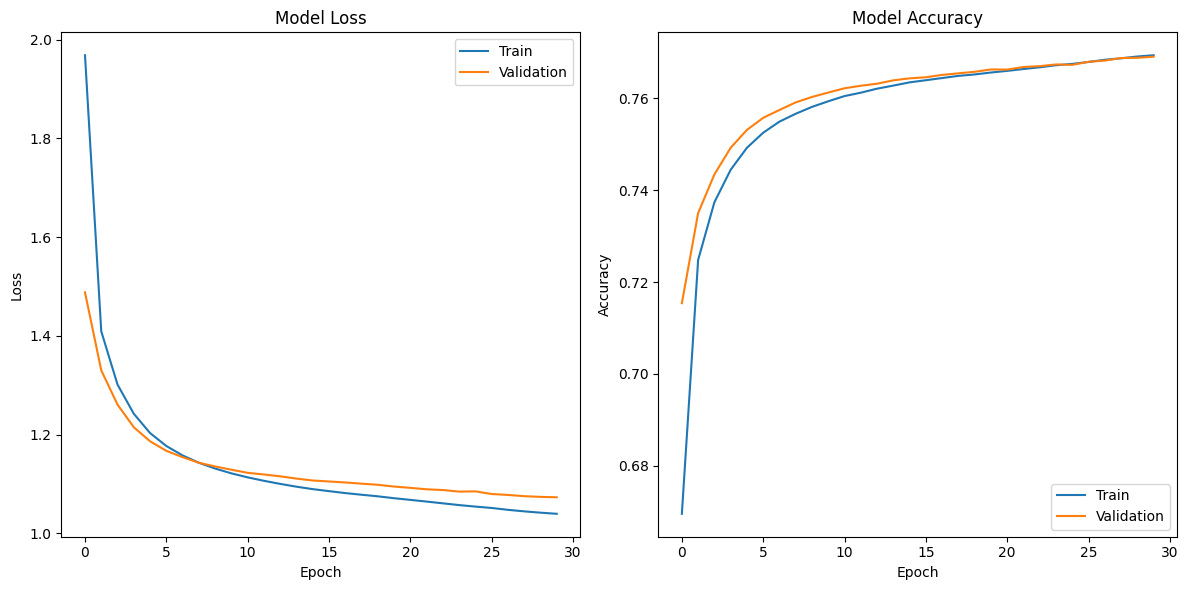

In [ ]:
# Plotting the training history for the model without attention

plot_history(history_no_att)

### Model with attention

Here we build the sequence-to-sequence model with attention.

In [13]:
# Model with attention

def create_recipe_model_with_att(vocab_size,
                                 max_title_length,
                                 max_ingredient_length,
                                 max_instructions_length,
                                 learning_rate=0.001,
                                 dropout_rate=0.0,
                                 embeddings_trainable=False):

    # Input layers

    title_input_with_att = tf.keras.layers.Input(shape=(max_title_length,),
                                                  dtype='int64',
                                                  name='title_input_with_att')

    ingredients_input_with_att = tf.keras.layers.Input(shape=(max_ingredient_length,),
                                                  dtype='int64',
                                                  name='ingredients_input_with_att')

    instructions_target_input_with_att = tf.keras.layers.Input(shape=(max_instructions_length,),
                                                  dtype='int64',
                                                  name='instructions_target_input_with_att')


    # Embedding layers, initialized with pre-trained weights

    title_embedding_layer_with_att = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                                output_dim=embedding_matrix.shape[1],
                                                                embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                                                input_length=max_title_length,
                                                                trainable=embeddings_trainable,
                                                                name='title_embedding_layer_with_att')

    ingredients_embedding_layer_with_att = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                                output_dim=embedding_matrix.shape[1],
                                                                embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                                                input_length=max_ingredient_length,
                                                                trainable=embeddings_trainable,
                                                                name='ingredients_embedding_layer_with_att')

    instructions_embedding_layer_with_att  = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                                 output_dim=embedding_matrix.shape[1],
                                                                 embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                                                 input_length=max_instructions_length,
                                                                 trainable=embeddings_trainable,
                                                                 name='instructions_embedding_layer_with_att')

    title_embeddings_with_att = title_embedding_layer_with_att(title_input_with_att)
    ingredients_embeddings_with_att = ingredients_embedding_layer_with_att(ingredients_input_with_att)
    instructions_embeddings_with_att = instructions_embedding_layer_with_att(instructions_target_input_with_att)

    # LSTM layers (encoder)
    title_lstm_layer_with_att = tf.keras.layers.LSTM(embedding_matrix.shape[1],
                                                     return_sequences=True,
                                                     return_state=True,
                                                     dropout=dropout_rate,
                                                     name='title_lstm_layer_with_att')
    title_out_with_att, title_state_h_with_att, title_state_c_with_att = title_lstm_layer_with_att(title_embeddings_with_att)

    ingredients_lstm_layer_with_att = tf.keras.layers.LSTM(embedding_matrix.shape[1],
                                                           return_sequences=True,
                                                           return_state=True,
                                                            dropout=dropout_rate,
                                                           name='ingredients_lstm_layer_with_att')
    ingredients_out_with_att, ingredients_state_h_with_att, ingredients_state_c_with_att = ingredients_lstm_layer_with_att(ingredients_embeddings_with_att)

    # Concatenate the outputs of the encoder (title and ingredients)
    encoder_concatenated_with_att = Concatenate(axis=1)([title_out_with_att,
                                                         ingredients_out_with_att])

    # LSTM layers (decoder)
    decoder_lstm_layer_with_att = tf.keras.layers.LSTM(embedding_matrix.shape[1],
                                                       return_sequences=True,
                                                       return_state=False,
                                                       dropout=dropout_rate,
                                                       name='decoder_lstm_layer_with_att')
    decoder_lstm_out_with_att = decoder_lstm_layer_with_att(instructions_embeddings_with_att)

    # Attention mechanism
    attention_layer = tf.keras.layers.Attention(name='attention_layer')
    context_vector_with_att = attention_layer([decoder_lstm_out_with_att,
                                               encoder_concatenated_with_att])

    # Concatenate decoder output with attention context vector
    concat_decoder_with_att = tf.keras.layers.Concatenate(axis=-1)([decoder_lstm_out_with_att,
                                                                    context_vector_with_att])

    # Output layer
    output_with_att = tf.keras.layers.Dense(vocab_size,
                                            activation='softmax',
                                            name='output_with_att')(concat_decoder_with_att)

    # Define the model
    model_with_att = tf.keras.models.Model(inputs=[title_input_with_att,
                                                   ingredients_input_with_att,
                                                   instructions_target_input_with_att],
                                           outputs=output_with_att)

    # Define the optimizer with the specified learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model_with_att.compile(optimizer=optimizer,
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

    return model_with_att



In [14]:
# Model with attention (model_att): Embeddings trainable, learning rate increased, and dropout added

model_att = create_recipe_model_with_att(vocab_size=vocab_size,
                                              max_title_length=MAX_LENGTH_ENCODER,
                                              max_ingredient_length=MAX_LENGTH_ENCODER,
                                              max_instructions_length=MAX_LENGTH_DECODER,
                                              learning_rate=0.005,
                                              dropout_rate=0.05,
                                              embeddings_trainable=True)

# Print model summary
model_att.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 title_input_with_att (Inpu  [(None, 95)]                 0         []                            
 tLayer)                                                                                          
                                                                                                  
 ingredients_input_with_att  [(None, 95)]                 0         []                            
  (InputLayer)                                                                                    
                                                                                                  
 instructions_target_input_  [(None, 260)]                0         []                            
 with_att (InputLayer)                                                                      

Training the model, or loading the weights if the model has already been trained:

In [15]:
# Define the file for saving/loading model weights

weights_file = 'model_att_weights.h5'
history_file = 'history_att.pkl'

# Check if the weights file exists
if os.path.exists(weights_file):
    # If weights exist, load them
    print("Loading model weights...")

    model_att.load_weights(weights_file)
    print("Model weights loaded successfully.")

    # Check if the history file exists
    if os.path.exists(history_file):
        # If history file exists, load training history
        print("Loading training history...")
        with open(history_file, 'rb') as file:
            history_att = pickle.load(file)
        print("Training history loaded successfully.")

else:
    # If weights do not exist, train the model and save the weights
    print("Training model with early stopping...")

    # Define early stopping callback
    early_stopping_callback = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                            patience=2,          # Number of epochs with no improvement after which training will be stopped
                                            restore_best_weights=True)  # Restore weights to the best epoch

    history_att = model_att.fit(x=[train_title_input_data, train_ingredient_input_data, train_input_instr_target],
                          y=train_output_instr_target,
                          validation_data=([test_title_input_data, test_ingredient_input_data, test_input_instr_target],
                                          test_output_instr_target),
                          epochs=30,
                          batch_size=128,
                          callbacks=[early_stopping_callback])

    # Save training history
    print("Saving training history...")
    with open(history_file, 'wb') as file:
        pickle.dump(history_att.history, file)
    print("Training history saved successfully.")

    # Save model weights
    model_att.save_weights(weights_file)
    print("Model trained and weights saved successfully.")



Loading model weights...
Model weights loaded successfully.
Loading training history...
Training history loaded successfully.


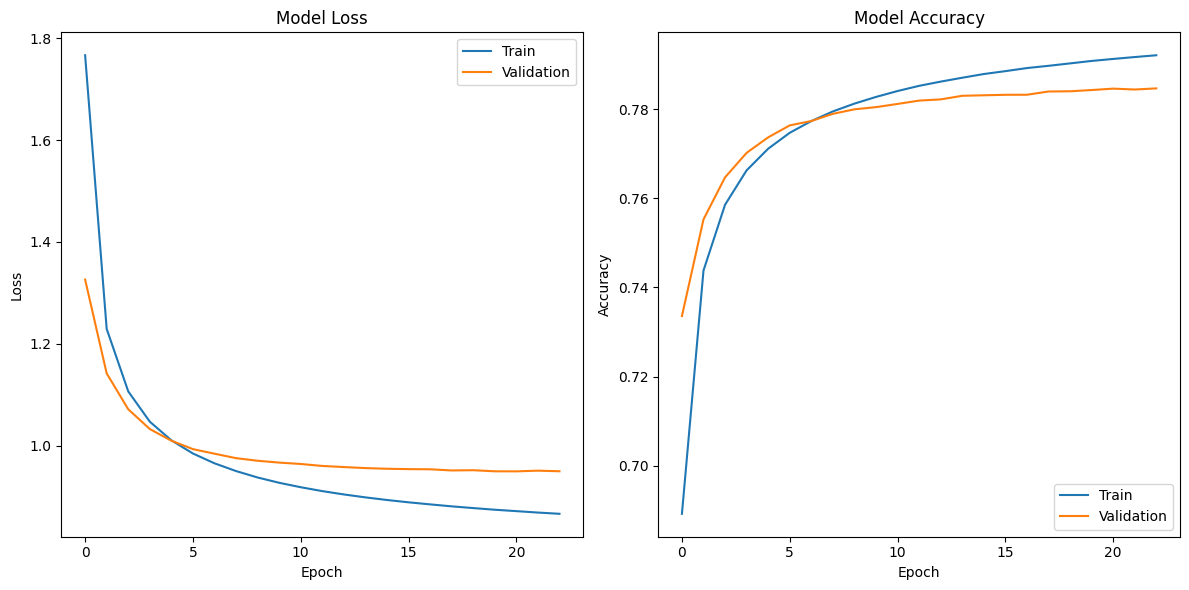

In [ ]:
# Plotting the training history for the model with attention

plot_history(history_att)

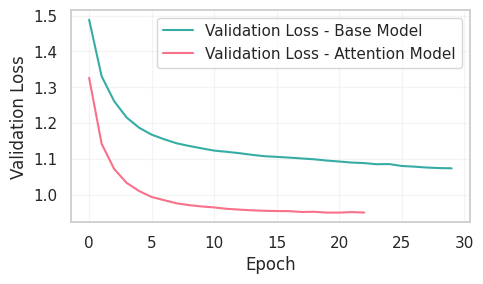

In [21]:
# Print validation loss from both models together

import seaborn as sns

def plot_validation_loss(history1, history2):
    sns.set(style="whitegrid")
    custom_palette = sns.color_palette("husl", 2)

    # Plot validation loss for each history
    plt.figure(figsize=(5, 3))
    sns.lineplot(data=history2['val_loss'], label='Validation Loss - Base Model', color=custom_palette[1])
    sns.lineplot(data=history1['val_loss'], label='Validation Loss - Attention Model', color=custom_palette[0])
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.legend()

    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig('validation_loss_plot.png', dpi=300)


    plt.show()


plot_validation_loss(history_att, history_no_att)


#Inference

In [16]:
# Inference function with beam search

def predict_instructions_beam_search(model, title_seq, ingredient_seq, max_len, beam_width, word_dict):
    # Initialize sequences and their probabilities
    start_token = pruned_word_to_index_dict['<START>']
    end_token = pruned_word_to_index_dict['<END>']
    initial_sequence = [start_token]
    sequences = [(initial_sequence, 0)]

    # Beam search loop
    for _ in range(max_len):
        all_candidates = []
        # Expand each sequence in the beam
        for seq, score in sequences:
            if seq[-1] == end_token:  # Check if the last token is <END>
                all_candidates.append((seq, score))  # Append current sequence without further expansion
                continue  # Skip further expansion if <END> token is reached

            # Predict the next word probabilities
            predictions = model.predict([title_seq, ingredient_seq, np.array([seq])], verbose=0)
            # Get the top beam_width candidates at this step
            top_candidates = heapq.nlargest(beam_width, range(len(predictions[0][-1])), predictions[0][-1].__getitem__)
            # Extend each sequence with the top candidates and calculate their scores
            for candidate in top_candidates:
                new_seq = seq + [candidate]
                new_score = score + np.log(predictions[0][-1][candidate])  # Add log probabilities
                all_candidates.append((new_seq, new_score))
        # Select top beam_width sequences
        sequences = heapq.nlargest(beam_width, all_candidates, key=lambda x: x[1])

    # Convert token IDs to words
    word_sequences = [[word_dict.get(token_id, '<UNK>') for token_id in seq[1:]] for seq, _ in sequences]

    # Return the sequence with the highest probability in word format
    return word_sequences[0]


In [17]:
# Generating one example to review using the model with attention

num = 1931
title_seq = test_title_input_data[num:num+1]  # Assuming title_seq is a single sequence
ingredient_seq = test_ingredient_input_data[num:num+1]  # Assuming ingredient_seq is a single sequence

predicted_instructions = predict_instructions_beam_search(model_att,
                                                          title_seq,
                                                          ingredient_seq,
                                                          MAX_LENGTH_DECODER,
                                                          5,
                                                          pruned_index_to_word_dict)

title_seq = test_title_input_data[num]
title_seq = tokens_to_words_no_padding(title_seq,pruned_index_to_word_dict)
print('Input title: ', ' '.join(title_seq))

ingredient_seq = test_ingredient_input_data[num]
ingredient_seq = tokens_to_words_no_padding(ingredient_seq,pruned_index_to_word_dict)
print('Input ingredients: ', ' '.join(ingredient_seq))

instructions_seq = test_output_instr_target[num]
instructions_seq = tokens_to_words_no_padding(instructions_seq,pruned_index_to_word_dict)
print('Actual instructions: ', ' '.join(instructions_seq))

# Print the generated instructions
print('Predicted instructions: ', ' '.join(predicted_instructions))


Input title:  kohlrabi pickles with chile oil
Input ingredients:  <NUM> pound small <UNK> peeled halved lengthwise thinly sliced crosswise . <NUM> teaspoon kosher salt . <NUM> garlic clove finely grated . <NUM> tablespoons coarsely chopped cilantro . <NUM> tablespoon unseasoned rice vinegar . <NUM> teaspoons chile oil . <NUM> teaspoon finely grated lime zest . <NUM> <NUM> teaspoons fresh lime juice . <NUM> teaspoon black sesame seeds . <NUM> teaspoon fish sauce . <NUM> teaspoon sugar . <NUM> teaspoon toasted sesame oil
Actual instructions:  toss <UNK> and salt in a large bowl to coat chill tossing occasionally <NUM> minutes . drain then toss in a clean large bowl with garlic cilantro vinegar chile oil lime zest lime juice sesame seeds fish sauce sugar and sesame oil to combine . <END>
Predicted instructions:  preheat oven to <NUM> degrees f. combine <NUM> cups water garlic and <NUM> teaspoon salt in a small bowl . add garlic and cilantro toss to combine . season with salt and pepper . 

Function for generating a set number recipe instructions based on the input tests data, and then saving off lists of the actual and predicted instructions.

In [18]:

def generate_instructions_clean(model, title_seqs, ingredient_seqs, output_seqs, max_len, beam_width, word_dict, num_samples):

    print("Generating recipe instructions...")
    predicted_instructions_list = []
    actual_instructions_list = []

    # Counter variable to track the number of recipes processed
    recipe_counter = 0

    # Iterate through random examples of the test data n times
    random.seed(42)  # Set seed for reproducibility
    random_indices = random.sample(range(len(title_seqs)), num_samples)
    for num in random_indices:
        title_seq = title_seqs[num:num+1]
        ingredient_seq = ingredient_seqs[num:num+1]

        # Generate predicted instructions
        predicted_instructions = predict_instructions_beam_search(model,
                                                                  title_seq,
                                                                  ingredient_seq,
                                                                  max_len,
                                                                  beam_width,
                                                                  word_dict)

        # Remove the end token from the predicted instructions
        if '<END>' in predicted_instructions:
          predicted_instructions.remove('<END>')

        # Get the corresponding actual instructions
        actual_instructions = output_seqs[num]

        # Remove the end token from the actual instructions
        if '<END>' in predicted_instructions:
          actual_instructions.remove('<END>')

        # Remove padding tokens from the actual instructions
        actual_instructions = tokens_to_words_no_padding(actual_instructions, word_dict)

        # Store each pair of text (predicted text and actual text)
        predicted_instructions_list.append(predicted_instructions)
        actual_instructions_list.append(actual_instructions)

        # Increment the recipe counter
        recipe_counter += 1

        # Print the recipe counter value every 5 recipes processed
        if recipe_counter % 5 == 0:
            print(f"{recipe_counter} recipes processed")

    print("All recipes processed.")

    return predicted_instructions_list, actual_instructions_list


Doing inference using the test set below. Because inference is slow, we limit the number of samples to 50 for each case. We perform inference using the same test examples across all variations of beam width and across both trained models.

Model without attention, beam width of 1 (greedy) and 5:

In [ ]:
predicted_instructions_list_NoAtt1, actual_instructions_list_NoAtt1 = generate_instructions_clean(model=model_no_att,
                                                                       title_seqs=test_title_input_data,
                                                                       ingredient_seqs=test_ingredient_input_data,
                                                                       output_seqs=test_output_instr_target,
                                                                       max_len=MAX_LENGTH_DECODER,
                                                                       beam_width=1,
                                                                       word_dict=pruned_index_to_word_dict,
                                                                       num_samples=50)

# Save the data for reference later on

with open('generated_instructions_NoAtt1.pkl', 'wb') as f:
    pickle.dump((predicted_instructions_list_NoAtt1, actual_instructions_list_NoAtt1), f)


Generating recipe instructions...
5 recipes processed
10 recipes processed
15 recipes processed
20 recipes processed
25 recipes processed
30 recipes processed
35 recipes processed
40 recipes processed
45 recipes processed
50 recipes processed
All recipes processed.


In [ ]:
predicted_instructions_list_NoAtt5, actual_instructions_list_NoAtt5 = generate_instructions_clean(model=model_no_att,
                                                                       title_seqs=test_title_input_data,
                                                                       ingredient_seqs=test_ingredient_input_data,
                                                                       output_seqs=test_output_instr_target,
                                                                       max_len=MAX_LENGTH_DECODER,
                                                                       beam_width=5,
                                                                       word_dict=pruned_index_to_word_dict,
                                                                       num_samples=50)

# Save the data for reference later on

with open('generated_instructions_NoAtt5.pkl', 'wb') as f:
    pickle.dump((predicted_instructions_list_NoAtt5, actual_instructions_list_NoAtt5), f)


Generating recipe instructions...
5 recipes processed
10 recipes processed
15 recipes processed
20 recipes processed
25 recipes processed
30 recipes processed
35 recipes processed
40 recipes processed
45 recipes processed
50 recipes processed
All recipes processed.


In [ ]:
predicted_instructions_list_NoAtt10, actual_instructions_list_NoAtt10 = generate_instructions_clean(model=model_no_att,
                                                                       title_seqs=test_title_input_data,
                                                                       ingredient_seqs=test_ingredient_input_data,
                                                                       output_seqs=test_output_instr_target,
                                                                       max_len=MAX_LENGTH_DECODER,
                                                                       beam_width=10,
                                                                       word_dict=pruned_index_to_word_dict,
                                                                       num_samples=50)

# Save the data for reference later on

with open('generated_instructions_NoAtt10.pkl', 'wb') as f:
    pickle.dump((predicted_instructions_list_NoAtt10, actual_instructions_list_NoAtt10), f)

Generating recipe instructions...
5 recipes processed
10 recipes processed
15 recipes processed
20 recipes processed
25 recipes processed
30 recipes processed
35 recipes processed
40 recipes processed
45 recipes processed
50 recipes processed
All recipes processed.


Model with attention, beam width of 1 (greedy) and 5:

In [ ]:
predicted_instructions_list_Att1, actual_instructions_list_Att1 = generate_instructions_clean(model=model_att,
                                                                       title_seqs=test_title_input_data,
                                                                       ingredient_seqs=test_ingredient_input_data,
                                                                       output_seqs=test_output_instr_target,
                                                                       max_len=MAX_LENGTH_DECODER,
                                                                       beam_width=1,
                                                                       word_dict=pruned_index_to_word_dict,
                                                                       num_samples=50)

# Save the data for reference later on

with open('generated_instructions_Att1.pkl', 'wb') as f:
    pickle.dump((predicted_instructions_list_Att1, actual_instructions_list_Att1), f)


Generating recipe instructions...
5 recipes processed
10 recipes processed
15 recipes processed
20 recipes processed
25 recipes processed
30 recipes processed
35 recipes processed
40 recipes processed
45 recipes processed
50 recipes processed
All recipes processed.


In [ ]:
predicted_instructions_list_Att5, actual_instructions_list_Att5 = generate_instructions_clean(model=model_att,
                                                                       title_seqs=test_title_input_data,
                                                                       ingredient_seqs=test_ingredient_input_data,
                                                                       output_seqs=test_output_instr_target,
                                                                       max_len=MAX_LENGTH_DECODER,
                                                                       beam_width=5,
                                                                       word_dict=pruned_index_to_word_dict,
                                                                       num_samples=50)

# Save the data for reference later on

with open('generated_instructions_Att5.pkl', 'wb') as f:
    pickle.dump((predicted_instructions_list_Att5, actual_instructions_list_Att5), f)


Generating recipe instructions...
5 recipes processed
10 recipes processed
15 recipes processed
20 recipes processed
25 recipes processed
30 recipes processed
35 recipes processed
40 recipes processed
45 recipes processed
50 recipes processed
All recipes processed.


In [ ]:
predicted_instructions_list_Att10, actual_instructions_list_Att10 = generate_instructions_clean(model=model_att,
                                                                       title_seqs=test_title_input_data,
                                                                       ingredient_seqs=test_ingredient_input_data,
                                                                       output_seqs=test_output_instr_target,
                                                                       max_len=MAX_LENGTH_DECODER,
                                                                       beam_width=10,
                                                                       word_dict=pruned_index_to_word_dict,
                                                                       num_samples=50)

# Save the data for reference later on

with open('generated_instructions_Att10.pkl', 'wb') as f:
    pickle.dump((predicted_instructions_list_Att10, actual_instructions_list_Att10), f)


Generating recipe instructions...
5 recipes processed
10 recipes processed
15 recipes processed
20 recipes processed
25 recipes processed
30 recipes processed
35 recipes processed
40 recipes processed
45 recipes processed
50 recipes processed
All recipes processed.


## Evaluation

Jump here if recipes have already been generated. Load the generated recipes:

In [19]:
# Load the pickle files for the base model

with open('generated_instructions_Att1.pkl', 'rb') as f:
    predicted_instructions_list_Att1, actual_instructions_list_Att1 = pickle.load(f)

with open('generated_instructions_Att5.pkl', 'rb') as f:
    predicted_instructions_list_Att5, actual_instructions_list_Att5 = pickle.load(f)

with open('generated_instructions_Att10.pkl', 'rb') as f:
    predicted_instructions_list_Att10, actual_instructions_list_Att10 = pickle.load(f)

# Load the pickle files for the attention model

with open('generated_instructions_NoAtt1.pkl', 'rb') as f:
    predicted_instructions_list_NoAtt1, actual_instructions_list_NoAtt1 = pickle.load(f)

with open('generated_instructions_NoAtt5.pkl', 'rb') as f:
    predicted_instructions_list_NoAtt5, actual_instructions_list_NoAtt5 = pickle.load(f)

with open('generated_instructions_NoAtt10.pkl', 'rb') as f:
    predicted_instructions_list_NoAtt10, actual_instructions_list_NoAtt10 = pickle.load(f)


In [25]:
# Save the random indices generated using the same seed

title_seqs=test_title_input_data
ingredient_seqs=test_ingredient_input_data
num_samples = 50

random.seed(42)
random_indices = random.sample(range(len(title_seqs)), num_samples)

# Initialize lists to store titles and ingredients corresponding to the generated instructions
actual_titles = []
actual_ingredients = []

# Iterate through the random indices to retrieve titles and ingredients
for num in random_indices:
    t = tokens_to_words_no_padding(title_seqs[num],pruned_index_to_word_dict)
    i = tokens_to_words_no_padding(ingredient_seqs[num],pruned_index_to_word_dict)
    actual_titles.append(t)
    actual_ingredients.append(i)

# Print the generated recipes along with their titles and ingredients
for i in range(num_samples):
    print(f'Recipe {i + 1}')
    print('Title:', ' '.join(actual_titles[i]))


    print('Ingredients:', ' '.join(actual_ingredients[i]))
    print('Actual instructions:', ' '.join(actual_instructions_list_Att5[i]))
    print('Predicted instructions with no attention and beam search of 1:', ' '.join(predicted_instructions_list_NoAtt1[i]))
    print('Predicted instructions with no attention and beam search of 5:', ' '.join(predicted_instructions_list_NoAtt5[i]))
    print('Predicted instructions with attention and beam search of 1:', ' '.join(predicted_instructions_list_Att1[i]))
    print('Predicted instructions with attention and beam search of 5:', ' '.join(predicted_instructions_list_Att5[i]))
    print()

Recipe 1
Title: antipasto pasta salad
Ingredients: <NUM> pound seashell pasta . <NUM> pound genoa salami chopped . <NUM> pound pepperoni sausage chopped . <NUM> pound asiago cheese diced . <NUM> can black olives drained and chopped . <NUM> red bell pepper diced . <NUM> green bell pepper chopped . <NUM> tomatoes chopped . <NUM> package dry italian style salad dressing mix . <NUM> cup extra virgin olive oil . <NUM> cup balsamic vinegar . <NUM> tablespoons dried oregano . <NUM> tablespoon dried parsley . <NUM> tablespoon grated parmesan cheese . salt and ground black pepper to taste
Actual instructions: cook the pasta in a large pot of salted boiling water until al dente . drain and cool under cold water . in a large bowl combine the pasta salami pepperoni asiago cheese black olives red bell pepper green bell pepper and tomatoes . stir in the envelope of dressing mix . cover and refrigerate for at least one hour . to prepare the dressing whisk together the olive oil balsamic vinegar orega

## Evaluation Functions

ROUGE:

In [32]:
# Set up NLTK stopwords
nltk.download('stopwords')

def compute_average_rouge_score(predictions, actuals):
    total_scores = {'rouge1': {'r': 0, 'p': 0, 'f': 0}, 'rougeL': {'r': 0, 'p': 0, 'f': 0}}
    num_samples = len(predictions)

    # Set up NLTK stopwords
    nltk.download('stopwords', quiet=True)
    stop_words = set(stopwords.words('english'))

    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

    for i in range(num_samples):
        predicted_text = predictions[i]
        actual_text = actuals[i]

        # Convert tokens to strings
        predicted_text = ' '.join(predicted_text)
        actual_text = ' '.join(actual_text)

        # Remove special tokens
        predicted_text = predicted_text.replace('<NUM>', '')
        actual_text = actual_text.replace('<NUM>', '')

        # Remove periods
        predicted_text = predicted_text.replace('.', '')
        actual_text = actual_text.replace('.', '')


        # Remove stopwords
        predicted_text = ' '.join([word for word in predicted_text.split() if word.lower() not in stop_words])
        actual_text = ' '.join([word for word in actual_text.split() if word.lower() not in stop_words])

        # Remove <END> token
        actual_text = actual_text.replace('<END>', '')

        # Compute ROUGE score for the current pair
        scores = scorer.score(actual_text, predicted_text)

        # Accumulate scores
        for metric, values in scores.items():
            total_scores[metric]['r'] += values[0]  # Recall value
            total_scores[metric]['p'] += values[1]  # Precision value
            total_scores[metric]['f'] += values[2]  # F1-score value

    # Compute average scores
    average_scores = {}
    for metric, values in total_scores.items():
        average_scores[metric] = {
            'r': values['r'] / num_samples,
            'p': values['p'] / num_samples,
            'f': values['f'] / num_samples
        }

    return average_scores


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


METEOR:

In [33]:

def compute_average_meteor_score(predictions, actuals):
    # Check if WordNet is downloaded, if not, download it

    stop_words = set(stopwords.words('english'))

    if 'corpora/wordnet' not in nltk.data.path:
        nltk.download('wordnet', quiet=True)

    # Set up NLTK stopwords
    nltk.download('stopwords', quiet=True)
    stop_words = set(stopwords.words('english'))

    # Initialize list to store individual METEOR scores
    meteor_scores = []

    # Iterate through each example
    for predicted_tokens, actual_tokens in zip(predictions, actuals):

        # Remove periods and <NUM> and <END> token
        predicted_tokens = [token for token in predicted_tokens if token not in ['.', '<NUM>', '<END>']]
        actual_tokens = [token for token in actual_tokens if token not in ['.', '<NUM>', '<END>']]

        # Remove stopwords
        predicted_tokens = [word for word in predicted_tokens if word.lower() not in stop_words]
        actual_tokens = [word for word in actual_tokens if word.lower() not in stop_words]

        # Compute METEOR score for the current example
        meteor_score_value = nltk.translate.meteor_score.meteor_score([actual_tokens], predicted_tokens)

        # Append the METEOR score to the list
        meteor_scores.append(meteor_score_value)

    # Compute the average METEOR score
    average_meteor_score = sum(meteor_scores) / len(meteor_scores)

    return average_meteor_score


In [ ]:
# List of pairs for each model

pairs_base = [(predicted_instructions_list_NoAtt1, actual_instructions_list_NoAtt1),
              (predicted_instructions_list_NoAtt5, actual_instructions_list_NoAtt5),
              (predicted_instructions_list_NoAtt10, actual_instructions_list_NoAtt10)]

# Define pairs for attention model
pairs_attention = [(predicted_instructions_list_Att1, actual_instructions_list_Att1),
                   (predicted_instructions_list_Att5, actual_instructions_list_Att5),
                   (predicted_instructions_list_Att10, actual_instructions_list_Att10)]

# Compute scores for base model
for i, (predicted, actual) in enumerate(pairs_base, start=1):
    beam_width = [1, 5, 10][i - 1]  # Choose beam width based on index
    meteor_score = compute_average_meteor_score(predicted, actual)
    rouge_score = compute_average_rouge_score(predicted, actual)
    print(f'Base Model without Attention, beam width of {beam_width}:')
    print('Meteor score:', meteor_score)
    print('Rouge score:', rouge_score)

# Compute scores for attention model
for i, (predicted, actual) in enumerate(pairs_attention, start=1):
    beam_width = [1, 5, 10][i - 1]  # Choose beam width based on index
    meteor_score = compute_average_meteor_score(predicted, actual)
    rouge_score = compute_average_rouge_score(predicted, actual)
    print(f'Attention Model, beam width of {beam_width}:')
    print('Meteor score:', meteor_score)
    print('Rouge score:', rouge_score)

Base Model without Attention, beam width of 1:
Meteor score: 0.15442645412157666
Rouge score: {'rouge1': {'r': 0.23416296312416002, 'p': 0.22652617657242627, 'f': 0.20668977505301694}, 'rougeL': {'r': 0.17404975680743714, 'p': 0.17097024797030208, 'f': 0.15383207940917318}}
Base Model without Attention, beam width of 5:
Meteor score: 0.15246941340079512
Rouge score: {'rouge1': {'r': 0.20643401808964212, 'p': 0.23938669242381028, 'f': 0.1986965087919311}, 'rougeL': {'r': 0.15214144617608855, 'p': 0.1754806346145856, 'f': 0.14534131644274453}}
Base Model without Attention, beam width of 10:
Meteor score: 0.15091202500521522
Rouge score: {'rouge1': {'r': 0.17840481678985257, 'p': 0.23551978012447627, 'f': 0.18557878983059148}, 'rougeL': {'r': 0.13676515578016266, 'p': 0.1801654417091648, 'f': 0.141415591449108}}
Attention Model, beam width of 1:
Meteor score: 0.2600141166055179
Rouge score: {'rouge1': {'r': 0.48118730672715093, 'p': 0.33769188440786563, 'f': 0.3747303553517931}, 'rougeL':

In [ ]:
for i in [6]:

  predicted_text = predicted_instructions_list_Att1[i]
  actual_text = actual_instructions_list_Att1[i]

  scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

  # Convert tokens to strings
  predicted_text = ' '.join(predicted_text)
  actual_text = ' '.join(actual_text)

  # Remove special tokens
  predicted_text = predicted_text.replace('<NUM>', '')
  actual_text = actual_text.replace('<NUM>', '')

  # Remove periods
  predicted_text = predicted_text.replace('.', '')
  actual_text = actual_text.replace('.', '')

  # Remove <END> token
  actual_text = actual_text.replace('<END>', '')


  # Remove stopwords
  predicted_text = ' '.join([word for word in predicted_text.split() if word.lower() not in stop_words])
  actual_text = ' '.join([word for word in actual_text.split() if word.lower() not in stop_words])

  # Compute ROUGE score for the current pair
  scores = scorer.score(actual_text, predicted_text)

  print(scores)
  print(predicted_text)
  print(actual_text)

{'rouge1': Score(precision=0.2413793103448276, recall=0.25, fmeasure=0.24561403508771928), 'rougeL': Score(precision=0.14655172413793102, recall=0.15178571428571427, fmeasure=0.14912280701754385)}
place beans large pot cover water bring boil cook beans tender minutes drain rinse beans cold water drain beans colander rinse cold water drain beans colander rinse cold water drain beans colander rinse cold water drain beans colander rinse cold water drain beans colander rinse beans cold water drain beans colander rinse beans cold water drain beans colander rinse beans cold water drain beans colander rinse beans cold water drain beans colander rinse beans cold water drain beans colander rinse beans cold water drain beans colander rinse beans cold water large bowl combine ground beef onions add ground beef ground beef mixture mix well add ground beef peppers mix well add tomatoes parsley season salt pepper
<UNK> soak dried beans according package directions drain pot combine beans enough wate

In [ ]:
for i in [6]:

  predicted_text = predicted_instructions_list_Att5[i]
  actual_text = actual_instructions_list_Att5[i]

  scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

  # Convert tokens to strings
  predicted_text = ' '.join(predicted_text)
  actual_text = ' '.join(actual_text)

  # Remove special tokens
  predicted_text = predicted_text.replace('<NUM>', '')
  actual_text = actual_text.replace('<NUM>', '')

  # Remove periods
  predicted_text = predicted_text.replace('.', '')
  actual_text = actual_text.replace('.', '')

  # Remove <END> token
  actual_text = actual_text.replace('<END>', '')


  # Remove stopwords
  predicted_text = ' '.join([word for word in predicted_text.split() if word.lower() not in stop_words])
  actual_text = ' '.join([word for word in actual_text.split() if word.lower() not in stop_words])

  # Compute ROUGE score for the current pair
  scores = scorer.score(actual_text, predicted_text)

  print(scores)
  print(predicted_text)
  print(actual_text)

{'rouge1': Score(precision=0.7428571428571429, recall=0.23214285714285715, fmeasure=0.35374149659863946), 'rougeL': Score(precision=0.5714285714285714, recall=0.17857142857142858, fmeasure=0.272108843537415)}
bring large pot lightly salted water boil add beans cook minutes tender still firm bite drain transfer large bowl add ground beef bell peppers onions chili powder cumin oregano stir tomatoes parsley season salt pepper
<UNK> soak dried beans according package directions drain pot combine beans enough water cover two inches bring boil reduce heat simmer beans almost tender hour <UNK> set eight quart dutch oven medium high heat batches add beef pork cook breaking meat spoon well browned transfer batch bowl using slotted spoon <UNK> heat drippings pot medium heat add bell peppers onions chili powder cumin seeds oregano cook stirring occasionally vegetables softened minutes add tomatoes juice reserved meat simmer one hour add beans simmer chili thickened beans tender hour longer stir p

In [ ]:
# Function to count non-padding tokens
def count_non_padding_tokens(instruction):
    return sum(1 for token in instruction if token != pruned_word_to_index_dict['<PAD>'])

# Calculate the lengths of test instructions excluding padding tokens
test_ingredient_lengths = [count_non_padding_tokens(instruction) for instruction in test_ingredient_input_data]
test_output_lengths = [count_non_padding_tokens(instruction) for instruction in test_output_instr_target]

# Compute the correlation coefficient
correlation_coefficient = np.corrcoef(test_ingredient_lengths, test_output_lengths)[0, 1]

print("Correlation Coefficient:", correlation_coefficient)

Correlation Coefficient: 0.482405124764566


In [ ]:
# Reload the train and test data
with open('train_test_data.pkl', 'rb') as f:
    (train_title_input_data, test_title_input_data,
     train_ingredient_input_data, test_ingredient_input_data,
     train_input_instr_target, test_input_instr_target,
     train_output_instr_target, test_output_instr_target) = pickle.load(f)

# Initialize a list to store combined lengths of ingredients and instructions
combined_lengths = []

# Iterate through the test data
for i in range(len(test_ingredient_input_data)):
    # Calculate the length of ingredients excluding padding tokens
    ingredient_length = len([token for token in test_ingredient_input_data[i] if token != pruned_word_to_index_dict['<PAD>']])

    # Calculate the length of instructions excluding padding tokens
    instruction_length = len([token for token in test_output_instr_target[i] if token != pruned_word_to_index_dict['<PAD>']])

    # Calculate the combined length
    combined_length = (ingredient_length + instruction_length) / 2  # Calculate average
    # Append tuple of index and combined length to the list
    combined_lengths.append((i, combined_length))

# Sort the list of tuples by combined length
sorted_combined_lengths = sorted(combined_lengths, key=lambda x: x[1])

# Extract the sorted indices
sorted_indices = [index for index, _ in sorted_combined_lengths]

# Use the sorted indices to sort the test data
sorted_ingredients = [test_ingredient_input_data[i] for i in sorted_indices]
sorted_instructions = [test_output_instr_target[i] for i in sorted_indices]


Creating quantiles by recipe lengths to do some experimentation.

In [ ]:
# Calculate the number of samples and quantile size
num = 10

num_samples = len(sorted_combined_lengths)
quantile_size = num_samples // num

# Initialize a dictionary to store quantiles
quantiles = {i: [] for i in range(num)}

# Iterate through the sorted combined lengths and assign each sample to a quintile
for i, (index, length) in enumerate(sorted_combined_lengths):
    quantile_index = min(i // quantile_size, num-1)  # Ensure we don't exceed the last quintile
    quantiles[quantile_index].append((index, length))

# Example of accessing the data for a specific quintile
first_quantile_data = quantiles[9][50]
print(first_quantile_data)
idx = first_quantile_data = first_quantile_data[0]

print(tokens_to_words_no_padding(test_title_input_data[idx], pruned_index_to_word_dict))
print(tokens_to_words_no_padding(test_ingredient_input_data[idx], pruned_index_to_word_dict))
print(tokens_to_words_no_padding(test_output_instr_target[idx], pruned_index_to_word_dict))

(18842, 134.5)
['fried', 'chicken']
['<NUM>', 'chicken', 'cut', 'up', 'into', '<NUM>', 'pieces', '.', 'kosher', 'salt', '.', '<NUM>', 'cups', 'all', 'purpose', 'flour', '.', '<NUM>', 'tablespoons', 'garlic', 'powder', '.', '<NUM>', 'tablespoons', 'onion', 'powder', '.', '<NUM>', 'tablespoons', 'sweet', 'paprika', '.', '<NUM>', 'teaspoons', 'cayenne', '.', 'freshly', 'ground', 'black', 'pepper', '.', '<NUM>', 'cups', 'buttermilk', '.', '<NUM>', 'tablespoons', 'hot', 'chili', 'sauce', 'such', 'as', '<UNK>', 'hot', 'chili', 'sauce', '.', 'peanut', 'oil', 'for', 'frying']
['put', 'the', 'chicken', 'pieces', 'into', 'a', 'large', 'bowl', '.', 'cover', 'the', 'chicken', 'with', 'water', 'by', '<NUM>', 'inch', 'add', '<NUM>', 'tablespoon', 'of', 'salt', 'for', 'each', 'quart', 'of', 'water', 'used', '.', 'cover', 'and', 'refrigerate', 'at', 'least', '<NUM>', 'hours', 'or', 'overnight', '.', 'in', 'a', 'large', 'shallow', 'platter', 'mix', 'the', 'flour', 'garlic', 'powder', 'onion', 'powder',

Testing with a specific example to ensure its working:

In [ ]:
quantile_index = 9

# Get the data for the specified quantile
quantile_data = quantiles[quantile_index]

# Extract the indices and lengths from the quantile data
quantile_indices = [index for index, _ in quantile_data]

# Extract the test data based on the indices
title_seqs_quantile = [test_title_input_data[idx] for idx in quantile_indices]
ingredient_seqs_quantile = [test_ingredient_input_data[idx] for idx in quantile_indices]
output_seqs_quantile = [test_output_instr_target[idx] for idx in quantile_indices]

num = 50

print(tokens_to_words_no_padding(title_seqs_quantile[num], pruned_index_to_word_dict))
print(tokens_to_words_no_padding(ingredient_seqs_quantile[num], pruned_index_to_word_dict))
print(tokens_to_words_no_padding(output_seqs_quantile[num], pruned_index_to_word_dict))

['fried', 'chicken']
['<NUM>', 'chicken', 'cut', 'up', 'into', '<NUM>', 'pieces', '.', 'kosher', 'salt', '.', '<NUM>', 'cups', 'all', 'purpose', 'flour', '.', '<NUM>', 'tablespoons', 'garlic', 'powder', '.', '<NUM>', 'tablespoons', 'onion', 'powder', '.', '<NUM>', 'tablespoons', 'sweet', 'paprika', '.', '<NUM>', 'teaspoons', 'cayenne', '.', 'freshly', 'ground', 'black', 'pepper', '.', '<NUM>', 'cups', 'buttermilk', '.', '<NUM>', 'tablespoons', 'hot', 'chili', 'sauce', 'such', 'as', '<UNK>', 'hot', 'chili', 'sauce', '.', 'peanut', 'oil', 'for', 'frying']
['put', 'the', 'chicken', 'pieces', 'into', 'a', 'large', 'bowl', '.', 'cover', 'the', 'chicken', 'with', 'water', 'by', '<NUM>', 'inch', 'add', '<NUM>', 'tablespoon', 'of', 'salt', 'for', 'each', 'quart', 'of', 'water', 'used', '.', 'cover', 'and', 'refrigerate', 'at', 'least', '<NUM>', 'hours', 'or', 'overnight', '.', 'in', 'a', 'large', 'shallow', 'platter', 'mix', 'the', 'flour', 'garlic', 'powder', 'onion', 'powder', 'paprika', 'an

Model without attention:

In [ ]:
# Initialize a dictionary to store the generated instructions for each quintile
var_len_generated_instr_NoAtt = {}
num_samples_per_quintile = 50
beam_width = 1

for i in[0,1,2,3,4,5,6,7,8,9]:
  quantile_index = i

  # Get the data for the specified quantile
  quantile_data = quantiles[quantile_index]

  # Extract the indices and lengths from the quantile data
  quantile_indices = [index for index, _ in quantile_data]

  # Extract the test data based on the indices
  title_seqs_quantile = test_title_input_data[quantile_indices]
  ingredient_seqs_quantile = test_ingredient_input_data[quantile_indices]
  output_seqs_quantile = test_output_instr_target[quantile_indices]

  # Generate instructions for the current quintile
  predicted_instructions, actual_instructions = generate_instructions_clean(model_no_att,
                                                                              title_seqs_quantile,
                                                                              ingredient_seqs_quantile,
                                                                              output_seqs_quantile,
                                                                              MAX_LENGTH_DECODER,
                                                                              beam_width,
                                                                              pruned_index_to_word_dict,
                                                                              num_samples_per_quintile)
  # Store the generated instructions for the current quintile
  var_len_generated_instr_NoAtt[i] = (predicted_instructions, actual_instructions)

  print(f"Instructions generated for quintile {i}")

# Save the generated instructions dictionary to a pickle file
pickle.dump(var_len_generated_instr_NoAtt, open("var_len_generated_instr_NoAtt.pkl", "wb"))


Generating recipe instructions...
5 recipes processed
10 recipes processed
15 recipes processed
20 recipes processed
25 recipes processed
30 recipes processed
35 recipes processed
40 recipes processed
45 recipes processed
50 recipes processed
All recipes processed.
Instructions generated for quintile 0
Generating recipe instructions...
5 recipes processed
10 recipes processed
15 recipes processed
20 recipes processed
25 recipes processed
30 recipes processed
35 recipes processed
40 recipes processed
45 recipes processed
50 recipes processed
All recipes processed.
Instructions generated for quintile 1
Generating recipe instructions...
5 recipes processed
10 recipes processed
15 recipes processed
20 recipes processed
25 recipes processed
30 recipes processed
35 recipes processed
40 recipes processed
45 recipes processed
50 recipes processed
All recipes processed.
Instructions generated for quintile 2
Generating recipe instructions...
5 recipes processed
10 recipes processed
15 recipes pr

Model with attention:

In [27]:
# Initialize a dictionary to store the generated instructions for each quintile
var_len_generated_instr_Att = {}
num_samples_per_quintile = 50
beam_width = 1

for i in[0,1,2,3,4,5,6,7,8,9]:
  quantile_index = i

  # Get the data for the specified quantile
  quantile_data = quantiles[quantile_index]

  # Extract the indices and lengths from the quantile data
  quantile_indices = [index for index, _ in quantile_data]

  # Extract the test data based on the indices
  title_seqs_quantile = test_title_input_data[quantile_indices]
  ingredient_seqs_quantile = test_ingredient_input_data[quantile_indices]
  output_seqs_quantile = test_output_instr_target[quantile_indices]

  # Generate instructions for the current quintile
  predicted_instructions, actual_instructions = generate_instructions_clean(model_att,
                                                                              title_seqs_quantile,
                                                                              ingredient_seqs_quantile,
                                                                              output_seqs_quantile,
                                                                              MAX_LENGTH_DECODER,
                                                                              beam_width,
                                                                              pruned_index_to_word_dict,
                                                                              num_samples_per_quintile)
  # Store the generated instructions for the current quintile
  var_len_generated_instr_Att[i] = (predicted_instructions, actual_instructions)

  print(f"Instructions generated for quintile {i}")

# Save the generated instructions dictionary to a pickle file
pickle.dump(var_len_generated_instr_Att, open("var_len_generated_instr_Att.pkl", "wb"))



Generating recipe instructions...
5 recipes processed
10 recipes processed
15 recipes processed
20 recipes processed
25 recipes processed
30 recipes processed
35 recipes processed
40 recipes processed
45 recipes processed
50 recipes processed
All recipes processed.
Instructions generated for quintile 0
Generating recipe instructions...
5 recipes processed
10 recipes processed
15 recipes processed
20 recipes processed
25 recipes processed
30 recipes processed
35 recipes processed
40 recipes processed
45 recipes processed
50 recipes processed
All recipes processed.
Instructions generated for quintile 1
Generating recipe instructions...
5 recipes processed
10 recipes processed
15 recipes processed
20 recipes processed
25 recipes processed
30 recipes processed
35 recipes processed
40 recipes processed
45 recipes processed
50 recipes processed
All recipes processed.
Instructions generated for quintile 2
Generating recipe instructions...
5 recipes processed
10 recipes processed
15 recipes p

In [30]:
# Attention

# Reload the generated instructions from the pickle file
generated_instructions_att = pickle.load(open("var_len_generated_instr_Att.pkl", "rb"))

# With attention

quintile_0_predicted_instructions_att, quintile_0_actual_instructions_att = generated_instructions_att[0]
quintile_1_predicted_instructions_att, quintile_1_actual_instructions_att = generated_instructions_att[1]
quintile_2_predicted_instructions_att, quintile_2_actual_instructions_att = generated_instructions_att[2]
quintile_3_predicted_instructions_att, quintile_3_actual_instructions_att = generated_instructions_att[3]
quintile_4_predicted_instructions_att, quintile_4_actual_instructions_att = generated_instructions_att[4]
quintile_5_predicted_instructions_att, quintile_5_actual_instructions_att = generated_instructions_att[5]
quintile_6_predicted_instructions_att, quintile_6_actual_instructions_att = generated_instructions_att[6]
quintile_7_predicted_instructions_att, quintile_7_actual_instructions_att = generated_instructions_att[7]
quintile_8_predicted_instructions_att, quintile_8_actual_instructions_att = generated_instructions_att[8]
quintile_9_predicted_instructions_att, quintile_9_actual_instructions_att = generated_instructions_att[9]

# No attention

# Reload the generated instructions from the pickle file
generated_instructions_noatt = pickle.load(open("var_len_generated_instr_NoAtt.pkl", "rb"))

quintile_0_predicted_instructions_noatt, quintile_0_actual_instructions_noatt = generated_instructions_noatt[0]
quintile_1_predicted_instructions_noatt, quintile_1_actual_instructions_noatt = generated_instructions_noatt[1]
quintile_2_predicted_instructions_noatt, quintile_2_actual_instructions_noatt = generated_instructions_noatt[2]
quintile_3_predicted_instructions_noatt, quintile_3_actual_instructions_noatt = generated_instructions_noatt[3]
quintile_4_predicted_instructions_noatt, quintile_4_actual_instructions_noatt = generated_instructions_noatt[4]
quintile_5_predicted_instructions_noatt, quintile_5_actual_instructions_noatt = generated_instructions_noatt[5]
quintile_6_predicted_instructions_noatt, quintile_6_actual_instructions_noatt = generated_instructions_noatt[6]
quintile_7_predicted_instructions_noatt, quintile_7_actual_instructions_noatt = generated_instructions_noatt[7]
quintile_8_predicted_instructions_noatt, quintile_8_actual_instructions_noatt = generated_instructions_noatt[8]
quintile_9_predicted_instructions_noatt, quintile_9_actual_instructions_noatt = generated_instructions_noatt[9]



In [34]:
# Define pairs for base model without attention
pairs_base_noatt = [(quintile_0_predicted_instructions_noatt, quintile_0_actual_instructions_noatt),
                    (quintile_1_predicted_instructions_noatt, quintile_1_actual_instructions_noatt),
                    (quintile_2_predicted_instructions_noatt, quintile_2_actual_instructions_noatt),
                    (quintile_3_predicted_instructions_noatt, quintile_3_actual_instructions_noatt),
                    (quintile_4_predicted_instructions_noatt, quintile_4_actual_instructions_noatt),
                    (quintile_5_predicted_instructions_noatt, quintile_5_actual_instructions_noatt),
                    (quintile_6_predicted_instructions_noatt, quintile_6_actual_instructions_noatt),
                    (quintile_7_predicted_instructions_noatt, quintile_7_actual_instructions_noatt),
                    (quintile_8_predicted_instructions_noatt, quintile_8_actual_instructions_noatt),
                    (quintile_9_predicted_instructions_noatt, quintile_9_actual_instructions_noatt)]

# Define pairs for attention model
pairs_attention = [(quintile_0_predicted_instructions_att, quintile_0_actual_instructions_att),
                    (quintile_1_predicted_instructions_att, quintile_1_actual_instructions_att),
                    (quintile_2_predicted_instructions_att, quintile_2_actual_instructions_att),
                    (quintile_3_predicted_instructions_att, quintile_3_actual_instructions_att),
                    (quintile_4_predicted_instructions_att, quintile_4_actual_instructions_att),
                    (quintile_5_predicted_instructions_att, quintile_5_actual_instructions_att),
                    (quintile_6_predicted_instructions_att, quintile_6_actual_instructions_att),
                    (quintile_7_predicted_instructions_att, quintile_7_actual_instructions_att),
                    (quintile_8_predicted_instructions_att, quintile_8_actual_instructions_att),
                    (quintile_9_predicted_instructions_att, quintile_9_actual_instructions_att)]

# Compute scores for base model without attention
for i, (predicted, actual) in enumerate(pairs_base_noatt, start=1):
    meteor_score = compute_average_meteor_score(predicted, actual)
    rouge_score = compute_average_rouge_score(predicted, actual)
    print(f'Base Model without Attention, Quintile {i}:')
    print('Meteor score:', meteor_score)
    print('Rouge score:', rouge_score)

# Compute scores for attention model
for i, (predicted, actual) in enumerate(pairs_attention, start=1):
    meteor_score = compute_average_meteor_score(predicted, actual)
    rouge_score = compute_average_rouge_score(predicted, actual)
    print(f'Attention Model, Quintile {i}:')
    print('Meteor score:', meteor_score)
    print('Rouge score:', rouge_score)

Base Model without Attention, Quintile 1:
Meteor score: 0.17386394313913717
Rouge score: {'rouge1': {'r': 0.16653329987212143, 'p': 0.2339209072830422, 'f': 0.17678307998591467}, 'rougeL': {'r': 0.1433994014499644, 'p': 0.2009346216012591, 'f': 0.15158828363891275}}
Base Model without Attention, Quintile 2:
Meteor score: 0.17635239618285772
Rouge score: {'rouge1': {'r': 0.19900530724930696, 'p': 0.2563645422081527, 'f': 0.20674573656099093}, 'rougeL': {'r': 0.16127574770318287, 'p': 0.20381798947750426, 'f': 0.16595598661418354}}
Base Model without Attention, Quintile 3:
Meteor score: 0.17812097085715758
Rouge score: {'rouge1': {'r': 0.2429527194647714, 'p': 0.24447537814816386, 'f': 0.22877079667654665}, 'rougeL': {'r': 0.19432982467872364, 'p': 0.19746215497859831, 'f': 0.18320302157901988}}
Base Model without Attention, Quintile 4:
Meteor score: 0.15405527232539484
Rouge score: {'rouge1': {'r': 0.23056837348139553, 'p': 0.20906266904292545, 'f': 0.20769842488251253}, 'rougeL': {'r':

In [35]:
def average_token_length(seq_list):
    total_tokens = sum(len(seq) for seq in seq_list)
    total_sequences = len(seq_list)
    return total_tokens / total_sequences

# Compute and print average token lengths for base model without attention
for i, (predicted, actual) in enumerate(pairs_base_noatt, start=1):
    avg_predicted_length = average_token_length(predicted)
    avg_actual_length = average_token_length(actual)
    print(f'Base Model without Attention, Quintile {i}:')
    print('Average predicted token length:', avg_predicted_length)
    print('Average actual token length:', avg_actual_length)

# Compute and print average token lengths for attention model
for i, (predicted, actual) in enumerate(pairs_attention, start=1):
    avg_predicted_length = average_token_length(predicted)
    avg_actual_length = average_token_length(actual)
    print(f'Attention Model, Quintile {i}:')
    print('Average predicted token length:', avg_predicted_length)
    print('Average actual token length:', avg_actual_length)

Base Model without Attention, Quintile 1:
Average predicted token length: 84.88
Average actual token length: 32.26
Base Model without Attention, Quintile 2:
Average predicted token length: 88.56
Average actual token length: 54.14
Base Model without Attention, Quintile 3:
Average predicted token length: 95.64
Average actual token length: 69.38
Base Model without Attention, Quintile 4:
Average predicted token length: 103.12
Average actual token length: 86.88
Base Model without Attention, Quintile 5:
Average predicted token length: 107.0
Average actual token length: 99.74
Base Model without Attention, Quintile 6:
Average predicted token length: 108.12
Average actual token length: 118.0
Base Model without Attention, Quintile 7:
Average predicted token length: 113.46
Average actual token length: 136.96
Base Model without Attention, Quintile 8:
Average predicted token length: 123.98
Average actual token length: 156.52
Base Model without Attention, Quintile 9:
Average predicted token length: 

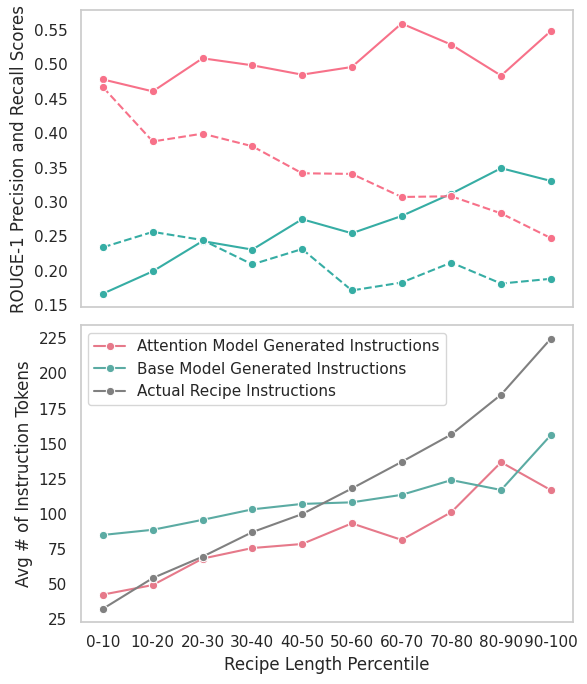

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define quintile labels for ROUGE score plot
quintile_labels_rouge = [f"{i}-{i+10}" for i in range(0, 100, 10)]

# Initialize lists to store recall and precision values
base_recall = []
base_precision = []
attention_recall = []
attention_precision = []

# Set style and palette
sns.set(style="whitegrid")
custom_palette = sns.color_palette("husl", 2)

# Extract recall and precision scores for the base model without attention
for i, (predicted, actual) in enumerate(pairs_base_noatt, start=1):
    meteor_score = compute_average_meteor_score(predicted, actual)
    rouge_score = compute_average_rouge_score(predicted, actual)
    base_recall.append(rouge_score['rouge1']['r'])
    base_precision.append(rouge_score['rouge1']['p'])

# Extract recall and precision scores for the attention model
for i, (predicted, actual) in enumerate(pairs_attention, start=1):
    meteor_score = compute_average_meteor_score(predicted, actual)
    rouge_score = compute_average_rouge_score(predicted, actual)
    attention_recall.append(rouge_score['rouge1']['r'])
    attention_precision.append(rouge_score['rouge1']['p'])

# Create a DataFrame for the base model
base_data = {'Quintile': quintile_labels_rouge,
             'Recall': base_recall,
             'Precision': base_precision,
             'Model': ['Base Model'] * len(quintile_labels_rouge)}

# Create a DataFrame for the attention model
attention_data = {'Quintile': quintile_labels_rouge,
                  'Recall': attention_recall,
                  'Precision': attention_precision,
                  'Model': ['Attention Model'] * len(quintile_labels_rouge)}

# Combine the data for both models
combined_data_rouge = pd.concat([pd.DataFrame(attention_data),pd.DataFrame(base_data)])

# Define quintile labels for token length plot
quintile_labels_length = [f"{i}-{i+10}" for i in range(0, 100, 10)]

# Initialize lists to store average token lengths
base_predicted_lengths = []
base_actual_lengths = []
attention_predicted_lengths = []
attention_actual_lengths = []

# Extract average token lengths for the base model without attention
for i, (predicted, actual) in enumerate(pairs_base_noatt, start=1):
    avg_predicted_length = average_token_length(predicted)
    avg_actual_length = average_token_length(actual)
    base_predicted_lengths.append(avg_predicted_length)
    base_actual_lengths.append(avg_actual_length)

# Extract average token lengths for the attention model
for i, (predicted, actual) in enumerate(pairs_attention, start=1):
    avg_predicted_length = average_token_length(predicted)
    avg_actual_length = average_token_length(actual)
    attention_predicted_lengths.append(avg_predicted_length)
    attention_actual_lengths.append(avg_actual_length)

# Create a DataFrame for the token lengths of the attention model
attention_token_length_data = {
    'Quintile': quintile_labels_length,
    'Average Predicted Length': attention_predicted_lengths,
    'Average Actual Length': attention_actual_lengths,
    'Model': ['Attention Model'] * len(quintile_labels_length)
}

# Create a DataFrame for the token lengths of the base model without attention
base_token_length_data = {
    'Quintile': quintile_labels_length,
    'Average Predicted Length': base_predicted_lengths,
    'Average Actual Length': base_actual_lengths,
    'Model': ['Base Model'] * len(quintile_labels_length)
}

# Combine the data for both models
combined_token_length_data = pd.concat([
    pd.DataFrame(attention_token_length_data),
    pd.DataFrame(base_token_length_data)
])

# Subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 7))

# Plot ROUGE scores
sns.lineplot(data=combined_data_rouge, x='Quintile', y='Recall', hue='Model', marker='o', palette=custom_palette, ax=ax1)
sns.lineplot(data=combined_data_rouge, x='Quintile', y='Precision', hue='Model', marker='o', linestyle='dashed', palette=custom_palette, ax=ax1)
ax1.set_ylabel('ROUGE-1 Precision and Recall Scores')
ax1.set_xlabel('')
ax1.grid(False)
ax1.set_xticklabels([])
ax1.legend().remove()

# Plot token lengths for the attention model
sns.lineplot(data=combined_token_length_data[combined_token_length_data['Model'] == 'Attention Model'], x='Quintile', y='Average Predicted Length', marker='o', color="#E6798A", label='Attention Model Generated Instructions', ax=ax2)

# Plot token lengths for the base model
sns.lineplot(data=combined_token_length_data[combined_token_length_data['Model'] == 'Base Model'], x='Quintile', y='Average Predicted Length', marker='o', color='#5BABA3', label='Base Model Generated Instructions', ax=ax2)

# Plot token lengths for the actual values
sns.lineplot(data=combined_token_length_data[combined_token_length_data['Model'] == 'Attention Model'], x='Quintile', y='Average Actual Length', marker='o', linestyle='-', color='grey', label='Actual Recipe Instructions', ax=ax2)

ax2.set_ylabel('Avg # of Instruction Tokens')
ax2.set_xlabel('Recipe Length Percentile')
ax2.grid(False)
ax2.legend()

plt.tight_layout()
plt.savefig('Metrics_by_length.png', dpi=300)


plt.show()
